In [1]:
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

data_dir = Path.cwd() / "data"

In [2]:
from langchain.document_loaders import PyPDFLoader

filename = "Allplan_2020_Manual.pdf"

loader = PyPDFLoader(f"{data_dir}/{filename}")

raw_data = loader.load()

In [3]:
texts = [page.page_content for page in raw_data]

texts = " ".join(texts)
texts = texts.replace("\n", "")

In [4]:
from chonkie import SentenceChunker

chunker = SentenceChunker(
    tokenizer="gpt2",            
    chunk_size=500,                 
    chunk_overlap=50,               
    min_sentences_per_chunk=1        
)

chunks = chunker(texts)

docs = [chunk.text for chunk in chunks]

print(len(docs))  # Should match the number of chunks

180


# GraphRAG

In [5]:
import numpy as np
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-2.5-flash", temperature=0.1, thinking_budget=0)

embedding_model = VertexAIEmbeddings(
    model_name="text-embedding-005"
)

embeddings = embedding_model.embed_documents(docs)

print(len(embeddings))

embeddings = np.array(embeddings)

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


180


In [6]:
from graph_rag import KnowledgeGraph

kg = KnowledgeGraph()

# Extract concepts for all chunks (batch)
concepts_per_chunk = kg.extract_concepts_batch(docs=docs)

# Create knowledge graph
G = kg.create_graph(
            embeddings=embeddings,
            docs=docs,
            concepts_per_chunk=concepts_per_chunk,
            k=5,
            metric="IP",
            save_dir=data_dir / "kg_graph",
            similarity_threshold=0.5,  # Only keep edges with cosine similarity >= 0.5
            concept_weight=0.3,  # 30% weight to concept overlap similarity metric
)

2025-10-26 22:29:43,079 - graph_rag - INFO - Initializing KnowledgeGraph 📈
2025-10-26 22:29:43,080 - graph_rag - INFO - Loading GLiNER NER model...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Extracting concepts / NER: 100%|██████████| 2/2 [00:37<00:00, 18.57s/it]
2025-10-26 22:30:24,283 - graph_rag - INFO - Saving adjacency list to directory: /Users/avosseler/Github_priv/graph-rag/data/kg_graph
2025-10-26 22:30:24,283 - graph_rag - INFO - Building kNN graph: 180 nodes, k=5, metric=IP


  Applying threshold: IP >=0.5


Building edges: 100%|██████████| 180/180 [00:00<00:00, 25003.30it/s]

✓ Created 900 edges
  Saved to: /Users/avosseler/Github_priv/graph-rag/data/kg_graph/graph_adjlist.txt
  Distance stats: mean=0.884, std=0.036
  Distance range: [0.696, 0.995]
Graph topology with concept enhancement:
  Nodes: 180
  Edges: 585
  Avg degree: 6.50


Visualize graph:

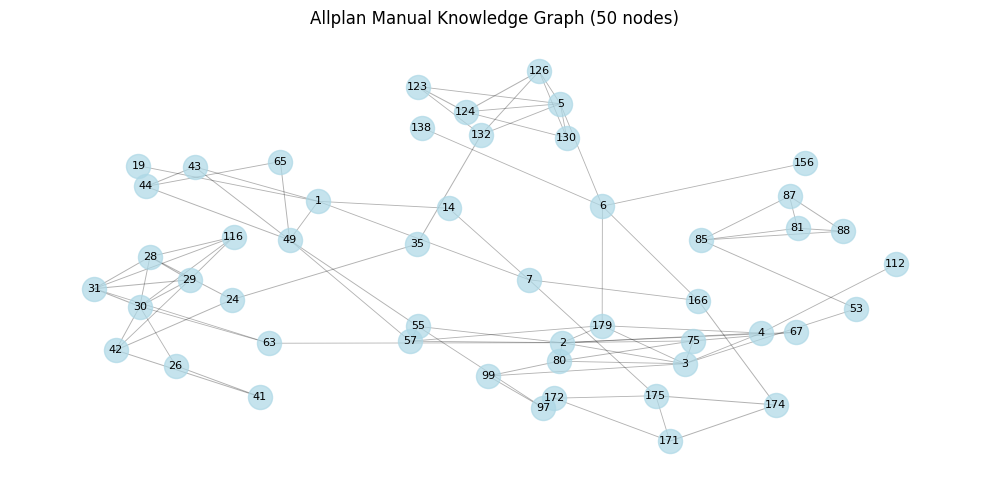

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

kg.visualize_graph_simple(G, max_nodes=50)

In [8]:
# kg.compute_centrality(G)

In [9]:
# Retrieve relevant subgraph for a user query
query = "How can I configure the Actionbar in Allplan?"

# 1.) Retrieve relevant nodes and neighborhood contexts
result = kg.retrieve(
    G=G,
    query=query,
    embedding_model=embedding_model,
    top_k=5,                 # number of semantic seed nodes
    k_hops=1,                # graph expansion radius
    text_attr="content",     # node attribute containing text
    centrality_weight=0.5    # weight of centrality in scoring
)

In [10]:
# Inspect result
print("Top-k nodes and scores:")
for node_id, score in result.get("top-k-nodes", []):
    print(f"  {node_id}: {score:.3f}")

print("\nNodes in neighborhood:", result["neighborhood"])

print("\nTexts passed to LLM:")
for node_id, text in result["contexts"]:
    print(f"- Node {node_id}: {text}")

# Pass concatenated texts to your LLM
context_text = "\n".join(t for _, t in result["contexts"])

prompt = f"""
Use the following context to answer the question.
{context_text}
Question: {query}
Answer:
"""

# 2.) Generate answer based on retrieved context:
llm_response = llm.invoke(prompt)

print(llm_response.content)


Top-k nodes and scores:
  19: 0.769
  22: 0.763
  20: 0.752
  23: 0.749
  21: 0.729

Nodes in neighborhood: [19, 22, 20, 23, 21, 1, 16, 18, 42]

Texts passed to LLM:
- Node 19: When you install for the first time or work with the Actionbar Configuration, the menu bar is hidden by default. You can show or hide the menu bar on the Quick Access Toolbar  (on page 21). Use the ALT KEY to show the menu bar for a short time. All the tools can be activated via the menus, regardless of the role or task you are working on.   Tip: To open a menu, you can also select the underlined letter in the menu name while selecting and holding the Alt key. 24 Actionbar Allplan 2020  Actionbar You can find the Actionbar  above the workspace (see "Working area" on page 19).  The Actionbar  contains all Allplan tools in groups of tools. The groups of tools are combined into task areas, which are combined into tasks. You can find the tasks required for each discipline in a role. To see the Actionbar , you must s

Show retrieved subgraph for query with top-k nodes ('seeds') in red and k-hop neighbors ('non-seeds') in blue

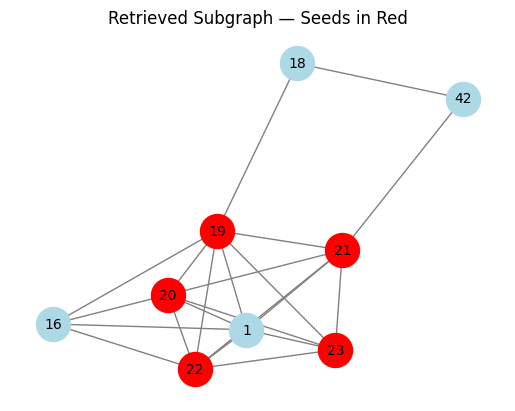

In [11]:
import matplotlib.pyplot as plt

SG = result["subgraph"]
seeds = [n for n, _ in result.get("top-k-nodes", [])]

pos = nx.spring_layout(SG, seed=42)

# draw edges
nx.draw_networkx_edges(SG, pos, edge_color="gray")

# draw non-seed nodes (light blue)
nx.draw_networkx_nodes(
    SG, pos,
    nodelist=[n for n in SG.nodes if n not in seeds],
    node_color="lightblue",
    node_size=600
)

# draw seed nodes (red)
nx.draw_networkx_nodes(
    SG, pos,
    nodelist=seeds,
    node_color="red",
    node_size=600
)

# draw node labels (indexes)
nx.draw_networkx_labels(SG, pos, labels={n: str(n) for n in SG.nodes()}, font_size=10)

plt.title("Retrieved Subgraph — Seeds in Red")
plt.axis("off")
plt.show()


### Langchain GraphRAG Pipeline

In [12]:
from graph_rag import GraphRAGRetriever

retriever = GraphRAGRetriever(
    kg=kg,
    embedding_model=embedding_model,
    top_k=5,
    k_hops=1,
)

In [13]:
from langchain.chains import RetrievalQA

docs = retriever.get_relevant_documents("How do I configure the Actionbar?")

for d in docs:
    print(d.metadata, d.page_content[:100])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
)

response = qa_chain.invoke({"query": "How do I configure the Actionbar in Allplan?"})
print(response["result"])


/var/folders/1p/xbhzldvj0qd22zz5f2qq_4mr0000gn/T/ipykernel_41342/2593494337.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("How do I configure the Actionbar?")


{'node_id': 22} Click Continue . If Allplan has found the text you entered in the box in the name of a tool, you can
{'node_id': 19} When you install for the first time or work with the Actionbar Configuration, the menu bar is hidden
{'node_id': 23} Without prompting you, Allplan saves all roles available in Actionbar Configurator  as a configurati
{'node_id': 16} The Actionbar configuration  is the default setting. This configuration consists of the Actionbar  s
{'node_id': 20} You can also make the Actionbar  float anywhere on your screen. By double-clicking, you can dock it 
{'node_id': 1} All other (registered) trademarks are the property of their respective owners.  © ALLPLAN GmbH, Muni
{'node_id': 15} Information, Hoti nfo, Updates   First Steps - Allplan QuickStart  This takes you to the Allplan web
{'node_id': 17}  You can find the Bimplus Login  on the right side. To go to the Allplan Shop, click the Open Allpla
{'node_id': 18} If the active viewport is an NDW file, the 22 Qui